<a href="https://colab.research.google.com/github/cs20m016/cs6910-Assignment-1/blob/main/Nadam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from random import randint
from random import random
from random import seed
import math
from sklearn.utils import shuffle

In [6]:
from keras.datasets import fashion_mnist

In [7]:
train_data,test_data=fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [8]:
train_data_mean = np.mean(train_data[0])
train_data_stdev = np.std(train_data[0])
train_data = ((train_data[0] - train_data_mean) / train_data_stdev, train_data[1])
test_data = ((test_data[0] - train_data_mean) / train_data_stdev, test_data[1])
train_X, trainY = train_data
test_X, testY = test_data

In [9]:
train_X, trainY = shuffle(train_X, trainY)
test_X, testY = shuffle(test_X, testY)

In [10]:
print('Train: X=%s, y=%s' %(train_X.shape,trainY.shape))
print('Test: X=%s, y=%s' %(test_X.shape,testY.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [11]:
class_label=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [12]:
sample=[]
for label in range(10):
    for i in range(len(testY)):
        if label==testY[i]:
            sample.append(test_X[i])
            break

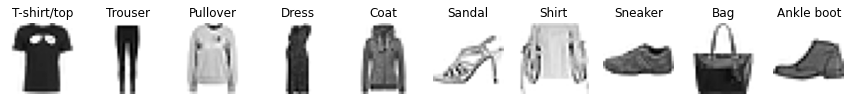

In [13]:
fig=plt.figure(figsize=(15,15))
rows=1
columns=10
for i in range(1, columns*rows +1):
    tg=sample[i-1]
    ax=fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(tg,cmap=plt.cm.binary)
    ax.title.set_text(class_label[i-1])
plt.show()

In [14]:
trainX=[train_X[i].flatten() for i in range(len(train_X))]
print(np.shape(trainX))
print(np.shape(trainY))

(60000, 784)
(60000,)


In [15]:
testX=[test_X[i].flatten() for i in range(len(test_X))]
print(np.shape(testX))
print(np.shape(testY))

(10000, 784)
(10000,)


In [16]:
train_samples=len(trainX)
test_samples=len(testX)
xlen=len(trainX[0])
print(xlen)

784


In [17]:
#No of Layers
L=3
#size of each hidden layer
N=8
#No of classes
K=10

In [18]:
def initialize_weights(n_input, n_hidden_layer, n_output,neurons_hl):
    W = list()
    W.append([[random() for j in range(n_input)]for i in range(neurons_hl)])
    for i in range(n_hidden_layer-1):
        W.append([[random() for j in range(neurons_hl)]for i in range(neurons_hl)])
    W.append([[random() for j in range(neurons_hl)]for i in range(n_output)])
    return W

In [19]:
def initialize_bias(n_input, n_hidden_layer, n_output,neurons_hl):
    B=list()
    for i in range(n_hidden_layer):
        B.append([random() for i in range(neurons_hl)])
    B.append([random() for i in range(n_output)])
    return B

In [20]:
def sigmoid(a):
  h=list()
  for el in a:
    h.append(1/(1+np.exp(-el)))
  return h

In [21]:
def softmax(a):
  h=list()
  sum=0
  for el in a:
    sum+=np.exp(el)
  for el in a:
    h.append(np.exp(el)/sum)
  return h

In [22]:
def feed_forward(input,W,B,L):
    H=list()
    A=list()
    H.append(input)
    A.append([0])
    for i in range(1,L):
        a=B[i-1]+np.matmul(W[i-1],H[i-1])
       # print(a)
        A.append(a)
       # print(h)
        H.append(sigmoid(a))
    a=B[L-1]+np.matmul(W[L-1],H[L-1])
    A.append(a)
   # print(a)
    hL=softmax(a)
   # print(hL)
    H.append(hL)
    return H,A,hL

In [23]:
def cmp(e):
  g=1/(1+np.exp(-e))
  return g*(1-g)

In [24]:
def diff_sigmoid(a):
    res=list()
    for el in a:
      res.append(cmp(el))
    return res

In [25]:
def back_propogation(H,A,y_hat,label,W):
    W_grad=list()
    B_grad=list()
    one_hot_y=np.zeros(K)
    one_hot_y[label]+=1
    ak_grad = y_hat-one_hot_y
    for k in range(L,0,-1):
        w_grad=np.matmul(np.matrix(ak_grad).T,np.matrix(H[k-1]))
        W_grad.append(w_grad)
        B_grad.append(ak_grad)
        if k != 1:
            h_grad=np.matmul(np.transpose(W[k-1]),ak_grad)
            ak_grad=np.multiply(h_grad,diff_sigmoid(A[k-1]))
    return W_grad,B_grad

In [26]:
eta=0.0001

In [27]:
def nadam():
    t,e=0,0
    epoch=5
    batch_size=128
    W= initialize_weights(xlen,L-1,K,N)
    B= initialize_bias(xlen,L-1,K,N)
    loss=list()
    points=0
    error=0.0
    epsilon=1e-10
    beta1=0.9
    beta2=0.999
    wgrad=list()
    bgrad=list()
    for l in range(L):
        wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
        bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())
    v_w=list()
    v_b=list()
    for l in range(L):
        v_w.append(np.zeros(shape=np.shape(W[l])).tolist())
        v_b.append(np.zeros(shape=np.shape(B[l])).tolist())
    m_w=list()
    m_b=list()
    for l in range(L):
        m_w.append(np.zeros(shape=np.shape(W[l])).tolist())
        m_b.append(np.zeros(shape=np.shape(B[l])).tolist())
    while (e<epoch):
        for i in range(train_samples):
            H,A,y_hat=feed_forward(trainX[i],W,B,L)
            error+=(-math.log(y_hat[trainY[i]]))
            W_grad,B_grad=back_propogation(H,A,y_hat,trainY[i],W)
            W_grad=W_grad[::-1]
            B_grad=B_grad[::-1]
            for l in range(L):
                wgrad[l]=(np.matrix(wgrad[l])+np.matrix(W_grad[l])).tolist()
                bgrad[l]=(bgrad[l]+np.multiply(1,B_grad[l])).tolist()
            points+=1
            if(points%batch_size==0):
                t+=1
                points=0
                loss.append(error/batch_size)
                error=0.0
                for l in range(L):
                    m_w[l]=(np.multiply(beta1,m_w[l])+np.multiply((1-beta1),wgrad[l])).tolist()
                    mwe=(np.divide(m_w[l],(1-(beta1**t)))).tolist()
                    v_w[l]=(np.multiply(beta2,v_w[l])+np.multiply((1-beta2),np.square(wgrad[l]))).tolist()
                    vwe=(np.divide(v_w[l],(1-(beta2**t)))).tolist()
                    tmp=vwe.copy()
                    new_t=np.add(epsilon,tmp).tolist()
                    rl=np.reciprocal([[float(j) for j in i] for i in np.sqrt(new_t)]).tolist()
                    mwe_up=(np.multiply(beta1,m_w[l])+np.multiply((1-beta1),wgrad[l])).tolist()
                    W[l]=(W[l]-np.multiply(mwe_up,np.multiply(eta,rl))).tolist()
                    m_b[l]=(np.multiply(beta1,m_b[l])+np.multiply((1-beta1),bgrad[l])).tolist()
                    mbe=(np.divide(m_b[l],(1-(beta1**t)))).tolist()
                    v_b[l]=(np.multiply(beta2,v_b[l])+np.multiply((1-beta2),np.square(bgrad[l]))).tolist()
                    vbe=(np.divide(v_b[l],(1-(beta2**t)))).tolist()
                    tmp1=vbe.copy()
                    new_t1=np.add(epsilon,tmp1).tolist()
                    rl1=np.reciprocal([float(i) for i in np.sqrt(new_t1)]).tolist()
                    mbe_up=(np.multiply(beta1,m_b[l])+np.multiply((1-beta1),bgrad[l])).tolist()
                    B[l]=np.subtract(B[l],np.multiply(mbe_up,np.multiply(eta,rl1))).tolist()              
                wgrad=list()
                bgrad=list()
                for l in range(L):
                    wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
                    bgrad.append(np.zeros(shape=np.shape(B[l])).tolist()) 
        e=e+1
        print('Epoch',e)
    return W,B,loss

In [28]:
W_r,B_r,loss=nadam()

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


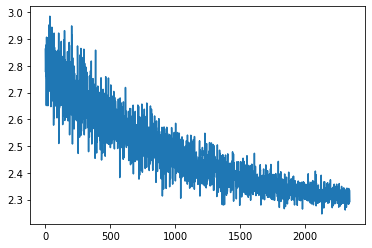

In [29]:
plt.plot(np.arange(1,len(loss)+1),loss)

In [32]:
#Prediction
valid=0
predict=[]
for i in range(test_samples):
    H,A,y_hat = feed_forward(testX[i],W_r,B_r,L)
    class_predict = y_hat.index(max(y_hat))
    predict.append(class_predict)
    if(class_predict==testY[i]):
      valid+=1

In [33]:
valid

1707